In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import IPython
import warnings
from IPython import display
warnings.filterwarnings('ignore')
from subprocess import check_output
%matplotlib inline

import os

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1a1d158470>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [66]:
data1 = pd.read_csv('train.csv')

Text(0.5,1,'data1')

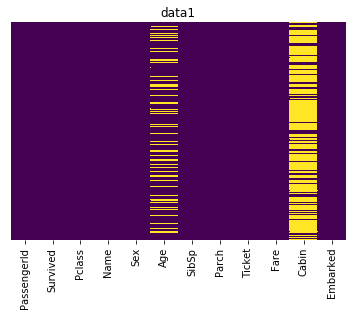

In [67]:
sns.heatmap(data1.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('data1')

Text(0.5,1,'data1')

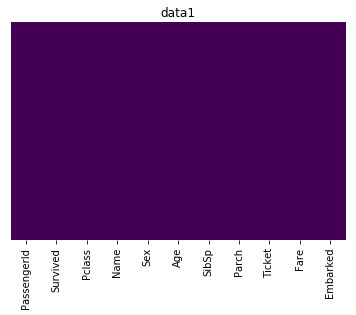

In [68]:
data1['Age'].fillna(data1['Age'].median(), inplace = True)
data1['Embarked'].fillna(data1['Embarked'].mode()[0], inplace = True)
data1['Fare'].fillna(data1['Fare'].median(), inplace = True) 
data1=data1.drop('Cabin', axis=1)

sns.heatmap(data1.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('data1')

In [69]:
data1['FamilySize'] = data1['SibSp'] + data1['Parch'] + 1
data1['IsAlone'] = 1
data1['IsAlone'].loc[data1['FamilySize'] > 1] = 0
data1['Title'] = data1['Name'].str.split(",", expand=True)[1].str.split(".", expand=True)[0]
data1['FareBin'] = pd.qcut(data1['Fare'], 4)
data1['AgeBin'] = pd.cut(data1['Age'].astype(int), 5)
    
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] ==True else x)

print(data1['Title'].value_counts())
print("-"*10)

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64
----------


In [70]:
label = LabelEncoder()

data1['Sex_Code'] = label.fit_transform(data1['Sex'])
data1['Embarked_Code'] = label.fit_transform(data1['Embarked'])
data1['Title_Code'] = label.fit_transform(data1['Title'])
data1['AgeBin_Code'] = label.fit_transform(data1['AgeBin'])
data1['FareBin_Code'] = label.fit_transform(data1['FareBin'])
    
Target = ['Survived']

data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_Misc'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


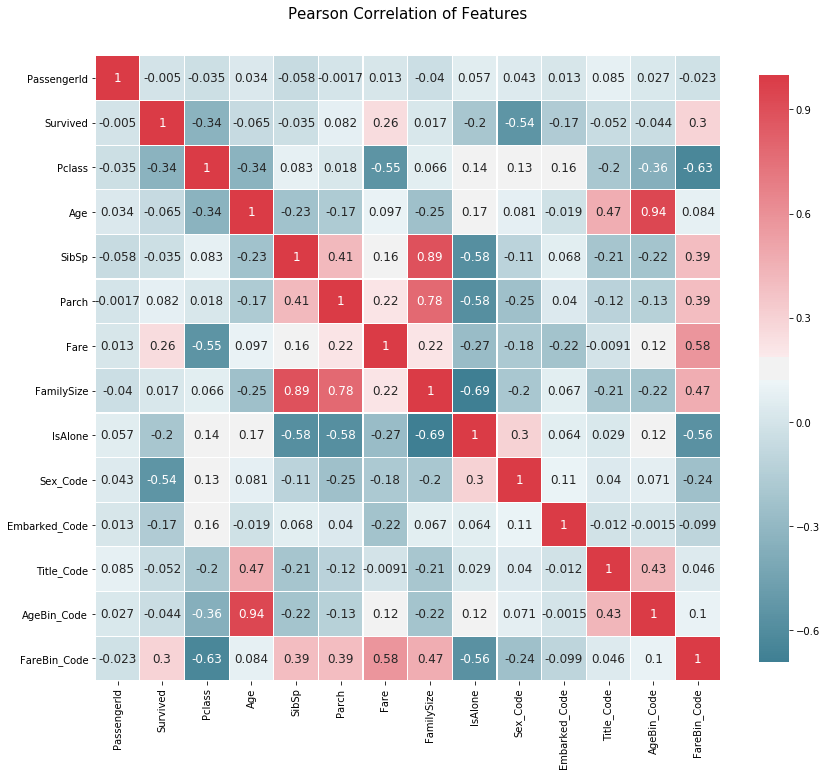

In [71]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

In [72]:
train1_x, test1_x, train1_y,  test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 21)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,1,0
68,0,3,2,1,7,1,1
253,1,3,2,2,2,1,2
320,1,3,2,2,1,1,0
706,0,2,2,3,1,2,1


In [73]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

In [74]:
models = {'XGB_depth3': xgb.XGBClassifier(max_depth=3, random_state=314, seed=314, silent=True),
          'XGB_depth5': xgb.XGBClassifier(max_depth=5, random_state=314, seed=314, silent=True),
          'XGB_depth7': xgb.XGBClassifier(max_depth=7, random_state=314, seed=314, silent=True),
          'XGB_depth7_regularised': xgb.XGBClassifier(max_depth=7, colsample_bytree= 0.9, reg_lambda= 1, subsample= 0.8, random_state=314, seed=314, silent=True),
          'LGB_depthINFleaves7': lgb.LGBMClassifier(max_depth=-1, num_leaves=7, random_state=314),
          'LGB_depthINFleaves20': lgb.LGBMClassifier(max_depth=-1, num_leaves=20, random_state=314),
          'LGB_depth3': lgb.LGBMClassifier(max_depth=3, random_state=314),
          'LGB_depth5': lgb.LGBMClassifier(max_depth=5, random_state=314),
          'Cat_depth3': cat.CatBoostClassifier(depth=3, random_state=314, silent=True),
          'Cat_depth5': cat.CatBoostClassifier(depth=5, random_state=314, silent=True),
          'Cat_depth7': cat.CatBoostClassifier(depth=7, random_state=314, silent=True),
          'Cat_depth9': cat.CatBoostClassifier(depth=9, random_state=314, silent=True)}


In [75]:
acc_valid_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
acc_train_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
fit_time_summary  = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)


def benchmarkModels(models_dict, transform_name='raw'):
    '''
    The function is used to evaluate performance of each algorithm
    
    Parameters
    ----------
    models_dict: dictionary 
        A dictionary of models for evaluation. 
        The items are name string and sklearn-like classifier pairs
    trasform_name: string
        Not used in this example, but allows one to evaluate performance on different data transformations
    '''
    for clf_name, clf in models_dict.items():
        clf.fit(train1_x_bin, train1_y_bin)
        acc_valid_summary.loc[clf_name, transform_name] = accuracy_score(test1_y_bin, clf.predict(test1_x_bin))
        acc_train_summary.loc[clf_name, transform_name] = accuracy_score(train1_y_bin, clf.predict(train1_x_bin))

In [76]:
def plotPerformance(perf_valid, perf_test, perf_fit_time=None, suff=''):
    n_plots = 3 if isinstance(perf_fit_time, pd.DataFrame) else 2
    
    fig, ax = plt.subplots(ncols=n_plots, figsize=(12,6))
    
    fig.subplots_adjust(wspace=1.25)
    
    
    sns.heatmap(perf_valid, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[0])
    ax[0].set_title('Accuracy on VALIDATION sample ' + suff)
    
    sns.heatmap(perf_test, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[1])
    ax[1].set_title('Accuracy on TRAIN sample ' + suff)
    
    if len(ax) > 2:
        sns.heatmap(perf_fit_time, cmap='Blues', annot=True, ax=ax[2])
        ax[2].set_title('Training time ' + suff)

In [77]:
benchmarkModels(models)

Learning rate set to 0.014946
Learning rate set to 0.014946
Learning rate set to 0.014946
Learning rate set to 0.014946


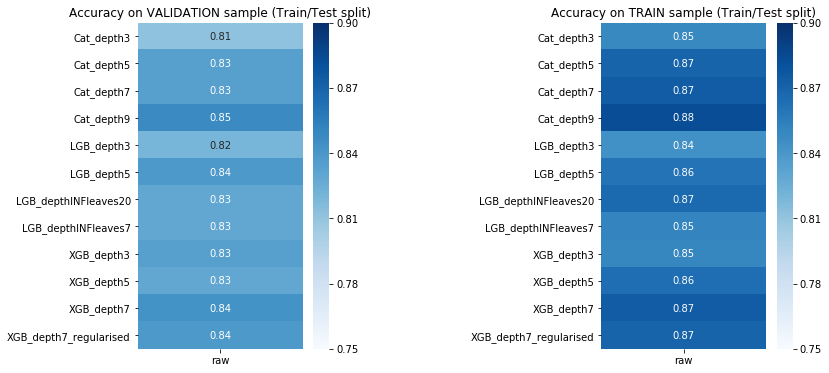

In [78]:
plotPerformance(acc_valid_summary, acc_train_summary, suff='(Train/Test split)')

In [79]:
acc_valid_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
acc_train_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
fit_time_cv_summary  = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)

In [83]:
def benchmarkModelsCV(models_dict, transform_name='raw'):
    for clf_name, clf in models_dict.items():
        score = cross_validate(clf,
                               X = train1_x_bin,
                               y = train1_y_bin,
                               scoring=make_scorer(accuracy_score, greater_is_better=True),
                               cv=5, 
                               return_train_score=True)
        acc_valid_cv_summary.loc[clf_name, transform_name] = score['test_score'].mean()
        acc_train_cv_summary.loc[clf_name, transform_name] = score['train_score'].mean()
        fit_time_cv_summary.loc[clf_name, transform_name] = score['fit_time'].mean()

In [84]:
benchmarkModelsCV(models)

Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014036
Learning rate set to 0.014036
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014036
Learning rate set to 0.014036
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014036
Learning rate set to 0.014036
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014029
Learning rate set to 0.014036
Learning rate set to 0.014036


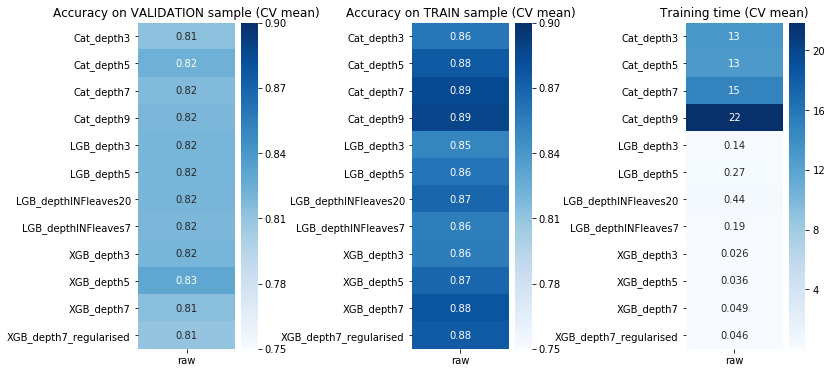

In [85]:
plotPerformance(acc_valid_cv_summary, acc_train_cv_summary, perf_fit_time=fit_time_cv_summary, suff='(CV mean)')